# Updated HDP HMM Evaluation Pipeline

In [2]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch
import numpy as np
from sklearn.model_selection import train_test_split

import logging

# Configure logging
logging.basicConfig(
    filename="hdp_training.log",  # output file name
    filemode="a",                 # append mode ("w" for overwrite)
    format="%(asctime)s - %(message)s",
    level=logging.INFO
)


def train_hdp(
    num_states,
    group_data,
    obs_dim,
    test_data=None,
    num_steps=3000,
    patience=500,
    min_delta=1e-3,
    verbose=True
):
    pyro.clear_param_store()

    elbo_trace = []
    best_loss = float("inf")
    patience_counter = 0

    def model(groups):
        gamma = torch.tensor(1.0)
        beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
        beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

        mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
        sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

        for g, seq in enumerate(groups):
            alpha = torch.tensor(1.0)
            pi = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha * beta[:-1]))
            with pyro.plate(f"obs_{g}", seq.shape[0]):
                z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
                pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

    def guide(groups):
        beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
        pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

        mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
        mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

        sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

        for g in range(len(groups)):
            beta_k_q = pyro.param("beta_k_q")
            pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
            pyro.sample(f"pi_{g}", dist.Dirichlet(pi_alpha))

    svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(num_steps):
        loss = svi.step(group_data)
        elbo_trace.append(loss)

        if verbose and step % 100 == 0:
            print(f"[{step}] Loss: {loss:.2f} (ELBO: {-loss:.2f})")

        if loss + min_delta < best_loss:
            if step != 0 and loss == best_loss:
                # Avoid logging same loss repeatedly
                continue
            best_loss = loss
            patience_counter = 0
            msg = f"New best loss at step {step}: {loss}"
            print(msg)
            logging.info(msg)
        else:
            patience_counter += 1
            msg = f"No improvement at step {step} (current loss: {loss}, best: {best_loss}) [patience={patience_counter}]"
            #print(msg)
            logging.info(msg)




        if patience_counter >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            break

    # --- Count active states ---
    beta_k_q = pyro.param("beta_k_q")
    pi_values = []
    
    for g in range(len(group_data)):
        pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
        pi = dist.Dirichlet(pi_alpha).mean  # Use the mean of the variational Dirichlet
        pi_values.append(pi)

    avg_pi = torch.stack(pi_values).mean(dim=0)
    active_states = (avg_pi > 0.01).sum().item()

    # --- Predictive log-likelihood (if test set provided) ---
    predictive_ll = None
    if test_data is not None:
        with torch.no_grad():
            mus = pyro.param("mus_loc")
            sigmas = pyro.param("sigmas_scale")
            test_lls = []
            for seq in test_data:
                log_probs = dist.Normal(mus, sigmas).log_prob(seq.unsqueeze(1))  # [T, K, D]
                test_lls.append(log_probs.sum(-1).logsumexp(dim=1).mean().item())
            predictive_ll = np.mean(test_lls)

    return {
        "elbo_trace": elbo_trace,
        "best_elbo": -best_loss,  # Use negative best loss as final ELBO
        "active_states": active_states,
        "predictive_loglik": predictive_ll
    }


/home/tim/miniforge3/envs/data_Challenges/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training with 5 states...
[0] Loss: 127752980.89 (ELBO: -127752980.89)
New best loss at step 0: 127752980.8927195
New best loss at step 1: 28239208.65815115
New best loss at step 5: 24903548.765533224
New best loss at step 22: 24400515.545798063
New best loss at step 31: 23853391.219453692
New best loss at step 32: 15311379.750331521
New best loss at step 39: 6493991.687711
[100] Loss: 376901424.12 (ELBO: -376901424.12)
New best loss at step 198: 5336359.002084732
[200] Loss: 922165725.77 (ELBO: -922165725.77)
[300] Loss: 5008512.97 (ELBO: -5008512.97)
New best loss at step 300: 5008512.967772245
[400] Loss: 6888839391249.46 (ELBO: -6888839391249.46)
New best loss at step 413: 3372596.0028579235
New best loss at step 477: 2573053.7722041607
[500] Loss: 65093711.53 (ELBO: -65093711.53)
New best loss at step 573: 1394946.0226151943
[600] Loss: 39797125.74 (ELBO: -39797125.74)
[700] Loss: 136837905.50 (ELBO: -136837905.50)
[800] Loss: 53543063.39 (ELBO: -53543063.39)
[900] Loss: 31593841

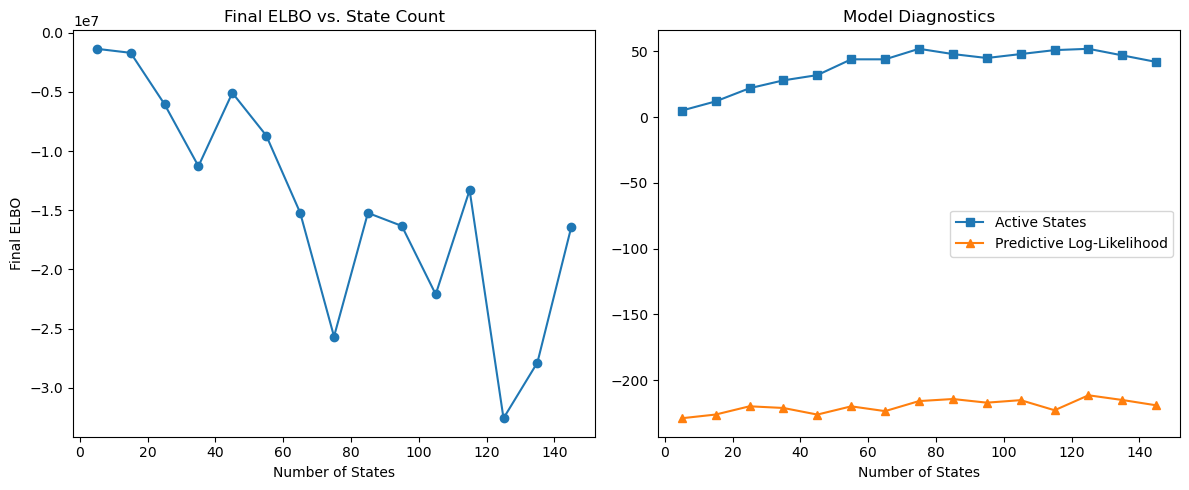

In [17]:
import matplotlib.pyplot as plt

# Split your group data into training and testing groups (if needed)
train_groups, test_groups = train_test_split(group_data, test_size=0.2, random_state=42)

candidate_states = list(range(5,150, 10))  # Finer granularity around promising range
results = []

for k in candidate_states:
    print(f"\nTraining with {k} states...")
    result = train_hdp(k, train_groups, obs_dim=obs_dim, test_data=test_groups)
    results.append((k, result))

# --- Plot Final ELBO and Active States ---
elbos = [r["best_elbo"] for _, r in results]
actives = [r["active_states"] for _, r in results]
predictive_ll = [r["predictive_loglik"] for _, r in results]
state_counts = [k for k, _ in results]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(state_counts, elbos, marker='o')
plt.xlabel("Number of States")
plt.ylabel("Final ELBO")
plt.title("Final ELBO vs. State Count")

plt.subplot(1, 2, 2)
plt.plot(state_counts, actives, marker='s', label="Active States")
plt.plot(state_counts, predictive_ll, marker='^', label="Predictive Log-Likelihood")
plt.xlabel("Number of States")
plt.title("Model Diagnostics")
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
max(elbos)

-322678.6319885254

# Pyro HDP-HSMM-Like Code

/tmp/ipykernel_71211/2000442920.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1746251340001/work/torch/csrc/utils/tensor_new.cpp:254.)
  group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
/home/tim/miniforge3/envs/data_Challenges/lib/python3.12/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'z_8', 'z_2', 'z_1', 'z_6', 'z_0', 'z_7', 'z_4', 'z_5', 'z_3'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Loaded 9 groups with 1776 total coins.
[0] ELBO: 1263968319.84


/home/tim/miniforge3/envs/data_Challenges/lib/python3.12/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'z_8', 'z_2', 'z_1', 'z_6', 'z_0', 'z_7', 'z_4', 'z_5', 'z_3'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[50] ELBO: 102490261187.76
[100] ELBO: 220004707542.62
[150] ELBO: 298100845.16
[200] ELBO: 1226236084.13
[250] ELBO: 1384796166.01
[300] ELBO: 8550150459.63
[350] ELBO: 9142537394.45
[400] ELBO: 20444652410.46
[450] ELBO: 6660631488.47
[500] ELBO: 300069952.55
[550] ELBO: 3619456202.04
[600] ELBO: 94782734.00
[650] ELBO: 206090107.35
[700] ELBO: 40494486350.97
[750] ELBO: 39032508.86
[800] ELBO: 6152537253.20
[850] ELBO: 437270847131.32
[900] ELBO: 788239921.32
[950] ELBO: 1900198594.76
[1000] ELBO: 75083981.64
[1050] ELBO: 1133135626559.14
[1100] ELBO: 270634165.95
[1150] ELBO: 2351513691.65
[1200] ELBO: 39172555.36
[1250] ELBO: 20293980.55
[1300] ELBO: 498093169084.41
[1350] ELBO: 1525410002.78
[1400] ELBO: 11217151645.19
[1450] ELBO: 596695714.96
[1500] ELBO: 683327253.93
[1550] ELBO: 48748432.08
[1600] ELBO: 2070259756.41
[1650] ELBO: 435317232.03
[1700] ELBO: 102383600.06
[1750] ELBO: 190858948.86
[1800] ELBO: 22558391514.32
[1850] ELBO: 723237713.28
[1900] ELBO: 622302375.06
[19

/tmp/ipykernel_71211/2000442920.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(group_data))


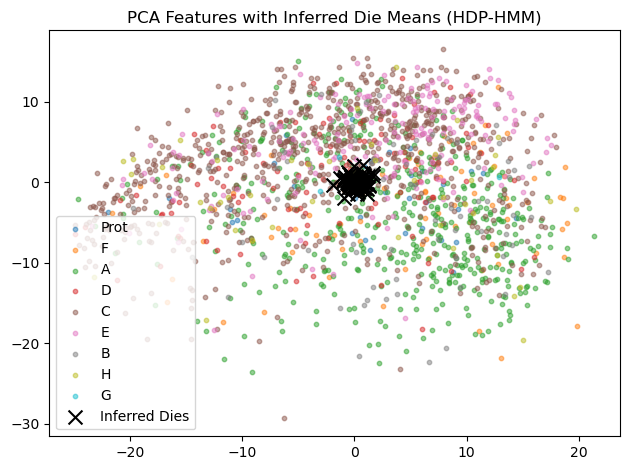

In [4]:
import pickle
import torch
from collections import defaultdict
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Setup
pyro.clear_param_store()
torch.manual_seed(0)
device = torch.device("cpu")

# Load saved features
with open("coin_features_pca_coin_clip.pkl", "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]
obs_dim = features.shape[1]

# Group features by label
grouped_features = defaultdict(list)
for feat, label in zip(features, labels):
    grouped_features[label].append(feat)

# Convert to torch tensors
group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
group_names = list(grouped_features.keys())

print(f"Loaded {len(group_data)} groups with {sum(len(g) for g in group_data)} total coins.")
# EXAMPLE DATA
#group_data = [
#    torch.cat(simulate_group([10, 15, 10], [[0, 0], [5, 5], [0, 0]])),
#    torch.cat(simulate_group([20, 10], [[5, 5], [8, -2]])),
#    torch.cat(simulate_group([12, 18], [[0, 0], [8, -2]]))
#]

# Ensure all are float32
#group_data = [seq.float() for seq in group_data]

# --- Hyperparameters for HDP ---
alpha_val = 0.5  # group-level concentration (sparsity in coin-to-die assignment)
gamma_val = 0.5  # global concentration (number of dies)
num_states = 82  # truncation level (max number of dies)
obs_dim = group_data[0].shape[1]  # dimensionality of feature vectors

# --- HDP Mixture Model ---
def model(groups):
    # Stick-breaking construction for beta (global die proportions)
    gamma = torch.tensor(gamma_val)
    beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
    beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)  # include final stick piece

    # Emission parameters (mean and stddev per die)
    mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

    # Group-level assignments
    for g, seq in enumerate(groups):
        alpha = torch.tensor(alpha_val)
        pi = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha * beta[:-1]))

        with pyro.plate(f"obs_{g}", seq.shape[0]):
            z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
            pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

# --- Guide (variational approximation) ---
def guide(groups):
    beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
    pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

    mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
    mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

    sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

    for g in range(len(groups)):
        alpha = torch.tensor(alpha_val)
        beta_k_q = pyro.param("beta_k_q")  # re-use from above
        pi_alpha = alpha * torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
        pyro.sample(f"pi_{g}", dist.Dirichlet(pi_alpha))

# --- Training ---
svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

num_steps = 2500
for step in range(num_steps):
    loss = svi.step(group_data)
    if step % 50 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")


# --- Posterior Visualization ---
#mus_post = pyro.param("mus_loc").detach()
#colors = ['red', 'blue', 'green']

#for i, seq in enumerate(group_data):
#    plt.scatter(seq[:, 0], seq[:, 1], color=colors[i], alpha=0.5, label=f'Group {i+1}')

#plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
#plt.title("Coin Feature Space with Inferred Die Means")
#plt.legend()
#plt.xlabel("Feature 1")
#plt.ylabel("Feature 2")
#plt.tight_layout()
#plt.show()

# Inferred die (state) locations
mus_post = pyro.param("mus_loc").detach().cpu()
colors = plt.cm.get_cmap('tab10', len(group_data))

# Plot group PCA features
for i, (group_tensor, name) in enumerate(zip(group_data, group_names)):
    arr = group_tensor.numpy()
    plt.scatter(arr[:, 0], arr[:, 1], label=name, alpha=0.5, s=10, color=colors(i))

# Plot inferred die means
plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
plt.title("PCA Features with Inferred Die Means (HDP-HMM)")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Step 1: Extract posterior parameters
mus = pyro.param("mus_loc").detach()
sigmas = pyro.param("sigmas_scale").detach()
beta_k_q = pyro.param("beta_k_q").detach()
beta = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])  # [num_states + 1]

# Load paths
image_paths = data["paths"]

# Assign image path to die
coin_to_die = []  # updated
idx = 0  # global index across all groups

for g, group in enumerate(group_data):
    pi_alpha = alpha_val * beta[:-1]
    pi_g = dist.Dirichlet(pi_alpha).mean

    log_probs = dist.Normal(mus, sigmas).log_prob(group.unsqueeze(1)).sum(-1) + pi_g.log()
    z_hat = log_probs.argmax(dim=1)

    for z in z_hat:
        coin_to_die.append({
            "group": group_names[g],
            "die_index": z.item(),
            "image_path": image_paths[idx]
        })
        idx += 1

# Now coin_to_die contains (group_name, coin_index, die_index)


In [6]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(coin_to_die)

# Save to CSV
output_csv = "coin_die_assignments.csv"
df.to_csv(output_csv, index=False)

print(f"Saved coin-to-die assignments to: {output_csv}")


Saved coin-to-die assignments to: coin_die_assignments.csv


In [12]:
from collections import Counter

# Count how often each die is used
die_counts = Counter([entry["die_index"] for entry in coin_to_die])

# Print top 10 most used dies
print("Top used dies:")
for die, count in die_counts.most_common(10):
    print(f"Die {die}: {count} coins")


Top used dies:
Die 31: 868 coins
Die 12: 235 coins
Die 27: 139 coins
Die 81: 82 coins
Die 56: 62 coins
Die 9: 44 coins
Die 32: 42 coins
Die 2: 31 coins
Die 15: 30 coins
Die 23: 29 coins


In [63]:
len(die_counts)

67

In [9]:
import openpyxl
from openpyxl.drawing.image import Image as OpenpyxlImage
from openpyxl.utils import get_column_letter

# Assuming you already have coin_to_die list of dicts:
# coin_to_die = [
#     {"group": ..., "die_index": ..., "image_path": ...},
#     ...
# ]

# Create workbook and worksheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Coin to Die Data"

# Write header row
headers = ["group", "die_index", "image_path", "image"]
for col_num, header in enumerate(headers, start=1):
    ws.cell(row=1, column=col_num, value=header)

# Starting from second row to write data
for row_num, entry in enumerate(coin_to_die, start=2):
    ws.cell(row=row_num, column=1, value=entry["group"])
    ws.cell(row=row_num, column=2, value=entry["die_index"])
    ws.cell(row=row_num, column=3, value=entry["image_path"])

    # Add image
    try:
        img = OpenpyxlImage(entry["image_path"])

        # Optionally resize images to fit better in cells (adjust as needed)
        max_width = 100  # pixels
        max_height = 100

        # Resize maintaining aspect ratio
        ratio_w = max_width / img.width
        ratio_h = max_height / img.height
        ratio = min(ratio_w, ratio_h, 1)  # Don't upscale images

        img.width = int(img.width * ratio)
        img.height = int(img.height * ratio)

        # Insert image into the 4th column of the current row
        cell_address = f"D{row_num}"
        ws.add_image(img, cell_address)

        # Optionally adjust row height to fit the image
        ws.row_dimensions[row_num].height = img.height * 0.75  # openpyxl uses points

        # Optionally set column width to fit images
        ws.column_dimensions[get_column_letter(4)].width = max_width / 7  # approx width in excel chars

    except FileNotFoundError:
        print(f"Image not found: {entry['image_path']}")
    except Exception as e:
        print(f"Error inserting image for row {row_num}: {e}")

# Save workbook
wb.save("coin_to_die_images_100_features.xlsx")


In [7]:
# Load saved features
with open("coin_features_pca_coin_clip.pkl", "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]
obs_dim = features.shape[1]

# Group features by label
grouped_features = defaultdict(list)
for feat, label in zip(features, labels):
    grouped_features[label].append(feat)

In [14]:
print((grouped_features["Prot"]))

[array([-1.1127717e+01, -3.2996218e+00,  1.7266108e+01, -1.7330801e-01,
       -6.4188976e+00, -7.0642757e+00, -1.2302818e+01, -5.9970326e+00,
       -7.5904354e-02,  2.8855078e+00,  2.5620019e+00, -4.6499858e+00,
        1.3316665e+00,  1.5044901e+00, -5.0143104e+00, -3.3256912e+00,
       -3.8025169e+00,  2.6576138e+00, -3.9955437e+00,  4.0296679e+00,
       -9.0655875e-01,  4.1659687e-02, -4.0917888e+00,  2.8599136e+00,
        1.4924978e-01, -1.4353595e+00, -2.7806515e-01, -1.2100881e+00,
       -1.3651798e+00, -2.8352278e-01, -1.0304674e+00,  1.2614961e+00,
       -5.2568072e-01,  2.2695470e+00, -9.2711741e-01,  1.5761086e+00,
       -2.1498954e+00, -5.7839620e-01, -9.4333845e-01, -2.4595389e+00,
       -2.2148494e-02,  1.1206766e+00, -5.6904805e-01, -1.8317023e-02,
       -1.1163602e-01,  1.4156477e+00, -1.0265733e+00, -9.7579145e-01,
       -1.1039603e-01,  5.5635691e-01, -5.9220426e-02,  1.9989152e-02,
        4.2757365e-01,  4.2886630e-01, -7.2329044e-01, -7.3200428e-01,
     

# Visualization of which die emitted which coin and to which group it belongs

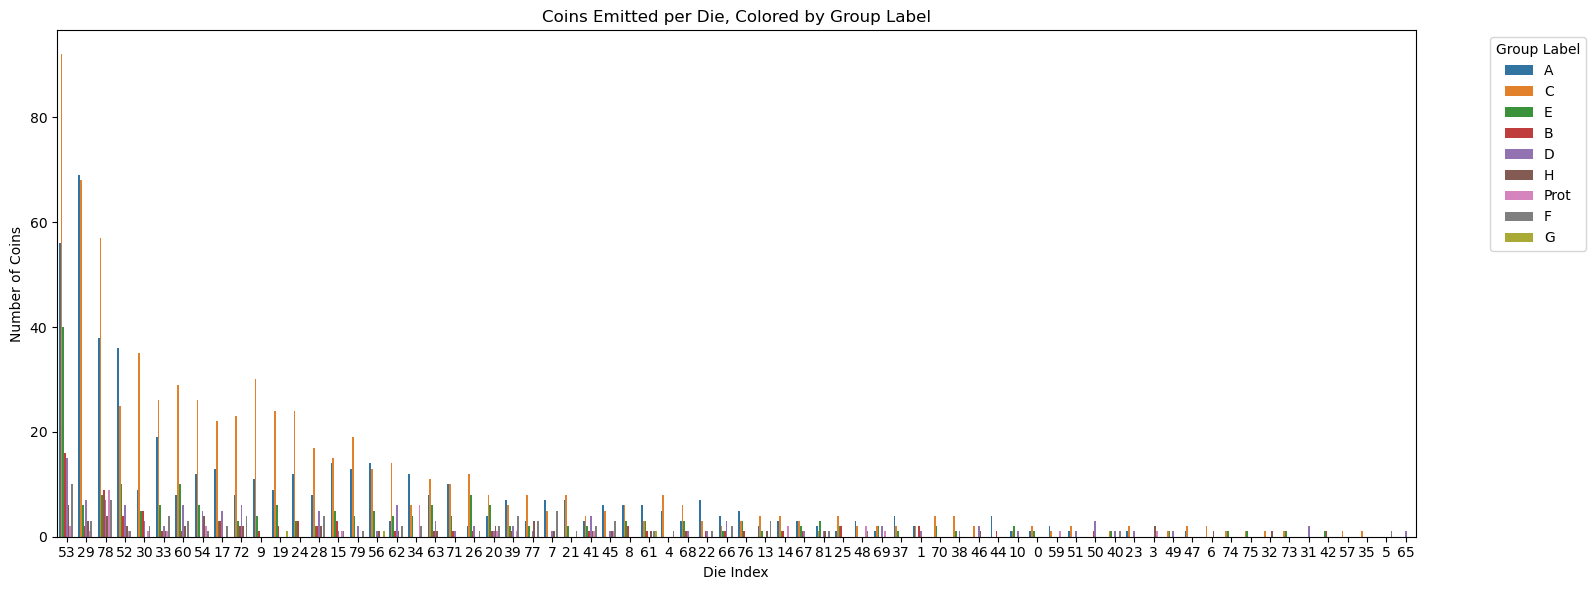

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load assignments
df = pd.read_csv("coin_die_assignments.csv")

# Count number of coins emitted per die per group
counts = df.groupby(["die_index", "group"]).size().reset_index(name="count")

# Sort dies by total coins emitted (optional for cleaner plotting)
total_per_die = counts.groupby("die_index")["count"].sum().sort_values(ascending=False)
ordered_dies = total_per_die.index.tolist()
counts["die_index"] = pd.Categorical(counts["die_index"], categories=ordered_dies, ordered=True)

# Plot
plt.figure(figsize=(16, 6))
sns.barplot(data=counts, x="die_index", y="count", hue="group", dodge=True)

plt.title("Coins Emitted per Die, Colored by Group Label")
plt.xlabel("Die Index")
plt.ylabel("Number of Coins")
#plt.yscale(value="log")
plt.legend(title="Group Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
